# Fine-tune GPT-3.5 on Excel data

### Import Libraries

In [1]:
from openai import OpenAI
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import json
import time
import random
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken

### Load dataset from Excel

In [2]:
# Load dataset from Excel
df = pd.read_excel('./data-excel/dataset_shuffled_1.xlsx')


def df_to_jsonl(df, output_path):
    conversations = []
    with open(output_path, 'w') as file:
        for _, row in df.iterrows():
            question = row['user']
            answer = row['assistant']

            conversation = {
                "messages": [
                    {"role": "system",
                     "content": "Anda adalah AI yang dilatih untuk memberikan informasi valid dan terperinci tentang penerimaan mahasiswa baru di Institut Teknologi PLN. Tugas Anda adalah menjawab semua pertanyaan pengguna dengan informasi yang akurat dan membantu mereka memahami proses penerimaan dengan baik."},
                    {"role": "user", "content": question},
                    {"role": "assistant", "content": answer}
                ]
            }

            conversations.append(conversation)
            file.write(json.dumps(conversation) + '\n')

    return conversations


output_path = './data-excel/dataset.jsonl'
converted_data = df_to_jsonl(df, output_path)


In [3]:
print(json.dumps(converted_data, indent=4, ensure_ascii=False))

[
    {
        "messages": [
            {
                "role": "system",
                "content": "Anda adalah AI yang dilatih untuk memberikan informasi valid dan terperinci tentang penerimaan mahasiswa baru di Institut Teknologi PLN. Tugas Anda adalah menjawab semua pertanyaan pengguna dengan informasi yang akurat dan membantu mereka memahami proses penerimaan dengan baik."
            },
            {
                "role": "user",
                "content": "Institut Teknologi PLN punya program studi S1 Rekayasa Sistem Komputer ga?"
            },
            {
                "role": "assistant",
                "content": "Untuk program studi S1 Rekayasa Sistem Komputer bakal ada kok di Institut teknologi PLN, tapi coming soon yahhh, jadi nantikan informasi selanjutnya di https://infopmb.itpln.ac.id/program-studi-itpln/"
            }
        ]
    },
    {
        "messages": [
            {
                "role": "system",
                "content": "Anda adalah AI yan

### Check JSONL file

In [4]:
with open(output_path, 'r') as file:
    for line_num, line in enumerate(file, 1):
        try:
            json.loads(line)
        except json.JSONDecodeError as e:
            print(f"Error in line {line_num}: {e}")

print("Format JSONL valid.")

Format JSONL valid.


In [5]:
def validate_structure(dataset):
    if not isinstance(dataset, dict):
        return False
    if "messages" not in dataset:
        return False
    if not isinstance(dataset["messages"], list):
        return False
    for message in dataset["messages"]:
        if not isinstance(message, dict):
            return False
        if "role" not in message or "content" not in message:
            return False
    return True


invalid_lines = []

# Validate the structure of each line in the JSONL file
with open(output_path, 'r') as file:
    for line_num, line in enumerate(file, 1):
        data = json.loads(line)
        if not validate_structure(data):
            invalid_lines.append(line_num)

if invalid_lines:
    print(f"Invalid structure in lines: {invalid_lines}")
else:
    print("All data structures are valid.")

All data structures are valid.


In [6]:
# Read JSONL file
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data


# check_data_quality function
def check_data_quality(data):
    issues = []
    for index, item in enumerate(data):
        messages = item.get('messages', [])
        if not messages:
            issues.append(f"Item {index}: 'messages' field is missing or empty.")
            continue
        for msg in messages:
            if 'role' not in msg or 'content' not in msg:
                issues.append(f"Item {index}: Missing 'role' or 'content' in message {msg}.")
            if msg['role'] not in ['system', 'user', 'assistant']:
                issues.append(f"Item {index}: Invalid role '{msg['role']}' in message {msg}.")
    return issues


# Load data from JSONL file
data = read_jsonl(output_path)

# Check data quality
issues = check_data_quality(data)

# Display data quality issues
if issues:
    print("Data Quality Issues Found:")
    for issue in issues:
        print(issue)
else:
    print("No data quality issues found.")

# Convert data to DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())

# Display the number of messages in each conversation
df['message_count'] = df['messages'].apply(len)
print(df['message_count'].describe())

# Display the distribution of message counts
message_lengths = []
for item in data:
    for msg in item['messages']:
        message_lengths.append(len(msg['content']))

message_lengths_series = pd.Series(message_lengths)
print(message_lengths_series.describe())


No data quality issues found.
                                            messages
0  [{'role': 'system', 'content': 'Anda adalah AI...
1  [{'role': 'system', 'content': 'Anda adalah AI...
2  [{'role': 'system', 'content': 'Anda adalah AI...
3  [{'role': 'system', 'content': 'Anda adalah AI...
4  [{'role': 'system', 'content': 'Anda adalah AI...
count    254.0
mean       3.0
std        0.0
min        3.0
25%        3.0
50%        3.0
75%        3.0
max        3.0
Name: message_count, dtype: float64
count    762.000000
mean     182.976378
std      116.147633
min       17.000000
25%       71.000000
50%      181.000000
75%      278.000000
max      949.000000
dtype: float64


### Count tokens in the dataset and estimate the cost of fine-tuning

In [30]:
def estimate_fine_tuning_cost(file_path, model="gpt-3.5-turbo"):
    # Define the cost parameters
    cost_per_token = 8.00 / 1_000_000  # Cost per token (e.g., $8.00 per 1M tokens for GPT-3.5 Turbo)
    cost_per_fine_tune = 8.00 / 1_000_000  # Assuming the fine-tuning cost is the same (adjust if necessary)

    # Load the data
    with open(file_path, "r") as file:
        data = [json.loads(line) for line in file]

    # Initialize the tokenizer for the specific model
    encoding_name = "cl100k_base"
    tokenizer = tiktoken.get_encoding(encoding_name)

    # Function to count tokens in a message using tiktoken
    def count_tokens_from_string(string: str) -> int:
        """Returns the number of tokens in a text string."""
        num_tokens = len(tokenizer.encode(string))
        return num_tokens

    def count_tokens(messages):
        total_tokens = 0
        for message in messages:
            total_tokens += count_tokens_from_string(message.get('role', ''))
            total_tokens += count_tokens_from_string(message.get('content', ''))
            total_tokens += count_tokens_from_string(message.get('name', ''))
        return total_tokens

    # Calculate the total number of tokens in the dataset
    total_tokens = sum(count_tokens(example["messages"]) for example in data)

    # Estimate the cost
    training_cost = total_tokens * cost_per_fine_tune
    usage_cost = total_tokens * cost_per_token

    total_cost = training_cost + usage_cost

    return total_tokens, training_cost, usage_cost, total_cost


# Estimate the cost
total_tokens, training_cost, usage_cost, total_cost = estimate_fine_tuning_cost(output_path)

# Display the results
print(f"Total Tokens: {total_tokens}")
print(f"Training Cost: ${training_cost:.2f}")
print(f"Usage Cost: ${usage_cost:.2f}")
print(f"Total Estimated Cost: ${total_cost:.2f}")

Total Tokens: 39431
Training Cost: $0.32
Usage Cost: $0.32
Total Estimated Cost: $0.63


### Split the dataset into training, validation, and testing sets

In [8]:
data_train = './data-excel/data_train.jsonl'
data_validation = './data-excel/data_validation.jsonl'
data_test = './data-excel/data_test.jsonl'


# Load data from JSONL file
def load_jsonl(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]


data = load_jsonl(output_path)

# Shuffle data
random.shuffle(data)

# Define split ratios
train_ratio = 0.8  # 80% training
validation_ratio = 0.1  # 10% validation
test_ratio = 0.1  # 10% testing

# Calculate split indices
train_index = int(len(data) * train_ratio)
validation_index = train_index + int(len(data) * validation_ratio)

# Split data into training, validation, and testing sets
train_data = data[:train_index]
validation_data = data[train_index:validation_index]
test_data = data[validation_index:]


# Save data to JSONL file
def save_jsonl(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for entry in data:
            f.write(json.dumps(entry) + '\n')


# Save training, validation, and testing data
save_jsonl(train_data, data_train)
save_jsonl(validation_data, data_validation)
save_jsonl(test_data, data_test)

print(f"Training data saved to {data_train}")
print(f"Validation data saved to {data_validation}")
print(f"Testing data saved to {data_test}")


Training data saved to ./data-excel/data_train.jsonl
Validation data saved to ./data-excel/data_validation.jsonl
Testing data saved to ./data-excel/data_test.jsonl


### Fine-tune GPT-3.5 on the training data

In [4]:
load_dotenv(dotenv_path='./apiKey.env')

openai_api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)

In [31]:
training_response = client.files.create(
    purpose='fine-tune',
    file=open(output_path, 'rb'),
)

training_file_id = training_response.id
print("Training file id:", training_file_id)

Training file id: file-UbbDNWmq8Iis0b6sarooxaoV


In [32]:
validation_response = client.files.create(
    purpose='fine-tune',
    file=open(data_validation, 'rb'),
)

validation_file_id = validation_response.id
print("Validation file id:", validation_file_id)

Validation file id: file-qNrxdVoaMcYNRoxBcjUipMfu


In [42]:
fine_tune_response = client.fine_tuning.jobs.create(
    model="gpt-3.5-turbo",
    training_file=training_file_id,
    validation_file=validation_file_id,
    suffix="bpa-2",
    hyperparameters={
        "n_epochs": 'auto',
        "batch_size": 'auto',
        "learning_rate_multiplier": 'auto'
    }
)

fine_tune_id = fine_tune_response.id

print(f"Fine-tuning started with ID: {fine_tune_id}")
print(fine_tune_response)

Fine-tuning started with ID: ftjob-Kb8qvhLxHiLvgNzciq0gWgwo
FineTuningJob(id='ftjob-Kb8qvhLxHiLvgNzciq0gWgwo', created_at=1722795248, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=10, batch_size=8, learning_rate_multiplier=0.0005), model='ft:gpt-3.5-turbo-0125:personal:bpa-3:9sZknZRN', object='fine_tuning.job', organization_id='org-lv4C6T43m3ZXCtmBwhwKWPU5', result_files=[], seed=1003715924, status='validating_files', trained_tokens=None, training_file='file-UbbDNWmq8Iis0b6sarooxaoV', validation_file='file-qNrxdVoaMcYNRoxBcjUipMfu', estimated_finish=None, integrations=[], user_provided_suffix='bpa-4')


In [43]:
while True:
    status_response = client.fine_tuning.jobs.retrieve(fine_tune_id)
    print(status_response)
    if status_response.status == 'succeeded':
        break
    time.sleep(60)  # Check every minute

# Get the fine-tuned model ID
result_response = client.fine_tuning.jobs.retrieve(fine_tune_id)
print(result_response)

FineTuningJob(id='ftjob-Kb8qvhLxHiLvgNzciq0gWgwo', created_at=1722795248, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=10, batch_size=8, learning_rate_multiplier=0.0005), model='ft:gpt-3.5-turbo-0125:personal:bpa-3:9sZknZRN', object='fine_tuning.job', organization_id='org-lv4C6T43m3ZXCtmBwhwKWPU5', result_files=[], seed=1003715924, status='running', trained_tokens=None, training_file='file-UbbDNWmq8Iis0b6sarooxaoV', validation_file='file-qNrxdVoaMcYNRoxBcjUipMfu', estimated_finish=None, integrations=[], user_provided_suffix='bpa-4')
FineTuningJob(id='ftjob-Kb8qvhLxHiLvgNzciq0gWgwo', created_at=1722795248, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=10, batch_size=8, learning_rate_multiplier=0.0005), model='ft:gpt-3.5-turbo-0125:personal:bpa-3:9sZknZRN', object='fine_tuning.job', organization_id='org-lv4C6T43m3ZXCt

In [44]:
status = client.fine_tuning.jobs.retrieve(fine_tune_id)
if status.status == "succeeded":
    print("Model is ready for use!")
    model_id = status.id
    model_runtime = status.finished_at - status.created_at
    model_trained_tokens = status.trained_tokens
    model_hyperparams = status.hyperparameters
    model_name = status.fine_tuned_model
    model_result_files = status.result_files
    print(f"Model name: {model_name}")
    print(f"Model runtime: {model_runtime} seconds")
    print(f"Model trained tokens: {model_trained_tokens}")
    print(f"Model hyperparameters: {model_hyperparams}")
    print(f"Model result files: {model_result_files}")
elif status.status == "running":
    print("Model is not ready yet, try again later")
else:
    print('status:', status.status)

Model is ready for use!
Model name: ft:gpt-3.5-turbo-0125:personal:bpa-4:9saIbJ1X
Model runtime: 1024 seconds
Model trained tokens: 419710
Model hyperparameters: Hyperparameters(n_epochs=10, batch_size=8, learning_rate_multiplier=0.0005)
Model result files: ['file-xq554O22tjzn1gWATvbSrLUt']


### Evaluate the fine-tuned model on the validation data

C:\Users\ramadhani.pratama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ramadhani.pratama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ramadhani.pratama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

              precision    recall  f1-score   support

Tidak sesuai       0.00      0.00      0.00      26.0
      Sesuai       0.00      0.00      0.00       0.0

    accuracy                           0.00      26.0
   macro avg       0.00      0.00      0.00      26.0
weighted avg       0.00      0.00      0.00      26.0



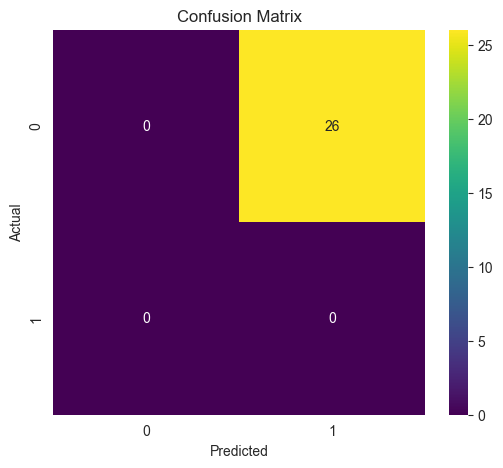

['Untuk program studi S1 Rekayasa Sistem Komputer bakal ada kok di Institut teknologi PLN, tapi coming soon yahhh, jadi nantikan informasi selanjutnya di https://infopmb.itpln.ac.id/program-studi-itpln/', 'Kami punya banyak pilihan! Mulai dari klub olahraga seperti futsal, basket, sampai klub robotik juga ada', 'Gampang banget kok kak, kakak cukup mengikuti informasi seminar lalu daftar melalui form. Untuk informasi seminarnya bisa dilihat disina kak https://itpln.ac.id/?s=seminar', 'Daftar matakuliah yang akan diampuh di prodi S1 Teknik Sipil bisa dilihat di https://infopmb.itpln.ac.id/s1-teknik-sipil/ \nKakak bisa scroll ke bawah di section "DAFTAR MATA KULIAH".', 'Kampus ITPLN terletak di Menara PLN, Jl. Lkr. Luar Barat, Duri Kosambi, Kecamatan Cengkareng, Kota Jakarta Barat, Daerah Khusus Ibukota Jakarta 11750', 'Keuntungan termasuk jaminan pekerjaan di PT PLN (Persero) setelah lulus. Info lebih lanjut di https://infopmb.itpln.ac.id/pendaftaran-mahasiswa-baru-program-ikatan-kerja-t

In [5]:
# Load test data


with open('./data-excel/data_test.jsonl', 'r') as f:
    test_data = [json.loads(line) for line in f]

true_responses = []
predicted_responses = []

# Evaluate model on test data
for item in test_data:
    messages = item['messages']

    response = client.chat.completions.create(
        model='gpt-3.5-turbo-0125',
        messages=messages[:-1]  # Exclude the assistant's response
    )

    predicted_completion = response.choices[0].message.content.strip()
    expected_completion = messages[-1]['content'].strip()

    true_responses.append(expected_completion)
    predicted_responses.append(predicted_completion)

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Fungsi untuk menghitung precision, recall, dan F1 score
def compute_f1_details(true_texts, predicted_texts):
    true_tokens = [text.split() for text in true_texts]
    predicted_tokens = [text.split() for text in predicted_texts]

    scores = []

    for idx, (true, pred) in enumerate(zip(true_tokens, predicted_tokens)):
        # Hitung jumlah token yang benar dan prediksi yang benar
        true_counter = Counter(true)
        pred_counter = Counter(pred)

        # Hitung true positives, false positives, dan false negatives
        tp = sum((true_counter & pred_counter).values())
        fp = sum((pred_counter - true_counter).values())
        fn = sum((true_counter - pred_counter).values())

        # Hitung precision, recall, dan F1
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        scores.append({
            'No': idx + 1,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    # Hitung rata-rata F1 score
    avg_f1_score = sum([score['F1 Score'] for score in scores]) / len(scores) if scores else 0
    scores.append({
        'No': 'Average',
        'Precision': '',
        'Recall': '',
        'F1 Score': avg_f1_score
    })

    return scores


# Hitung F1 scores untuk sebelum dan sesudah fine-tuning
f1_scores_before = compute_f1_details(true_responses_before_fine_tuning, predicted_responses_before_fine_tuning)
f1_scores_after = compute_f1_details(true_responses, predicted_responses)

# Konversi ke DataFrame untuk ditampilkan
df_f1_scores_before = pd.DataFrame(f1_scores_before)
df_f1_scores_after = pd.DataFrame(f1_scores_after)

# Tampilkan tabel F1 scores sebelum fine-tuning
print("F1 Scores Before Fine-Tuning:")
print(df_f1_scores_before.to_string(index=False))

# Tampilkan tabel F1 scores sesudah fine-tuning
print("\nF1 Scores After Fine-Tuning:")
print(df_f1_scores_after.to_string(index=False))

# Visualisasi Bar Chart Perbandingan
f1_before = df_f1_scores_before[df_f1_scores_before['No'] == 'Average']['F1 Score'].values[0]
f1_after = df_f1_scores_after[df_f1_scores_after['No'] == 'Average']['F1 Score'].values[0]

labels = ['F1-Score Before', 'F1-Score After']
f1_values = [f1_before, f1_after]

plt.figure(figsize=(6, 4))
plt.bar(labels, f1_values, color=['blue', 'green'])
plt.title('Comparison of F1-Score Before and After Fine-Tuning')
plt.ylim(0, 1)
plt.ylabel('F1-Score')
plt.show()
